# 07 — Feature Importance Analysis

This notebook provides interpretation for the feature importance for the Random forest, XGBoost and Decision Tree models similar to Table 2 in Jannani et al. paper. 

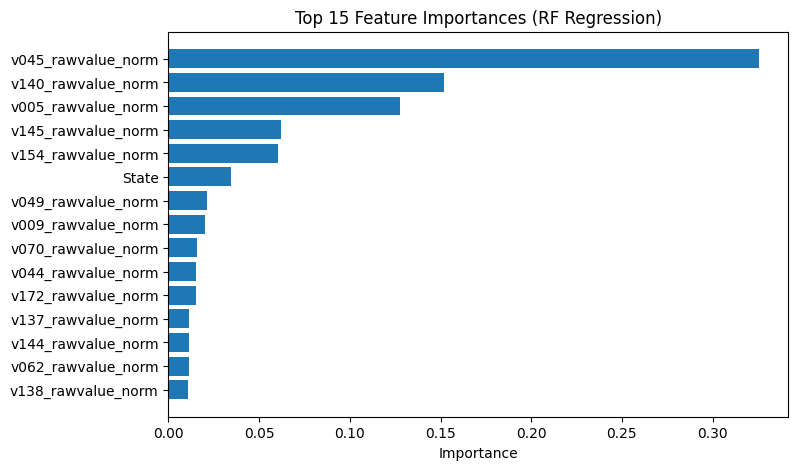

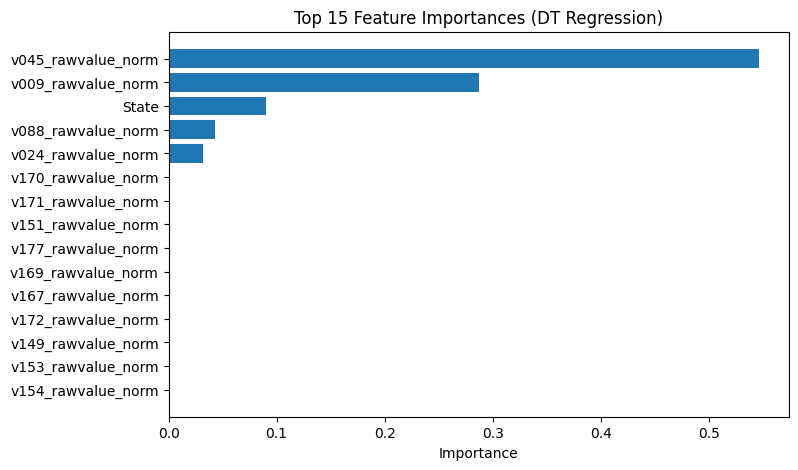

In [12]:
import joblib, pandas as pd, matplotlib.pyplot as plt, numpy as np

lib_file = [
    "../results/models/RandomForestRegress_best.joblib",
    "../results/models/DecisionTreeRegress_best.joblib"
]

for file in lib_file:
    model = joblib.load(file)
    features = pd.read_csv("../results/norm_predictors/final_predictor_index_all_years.csv")
    imp = model.feature_importances_
    plt.figure(figsize=(8,5))
    indices = np.argsort(imp)[::-1]
    plt.barh(np.array(features.columns)[indices][:15], imp[indices][:15])
    if "RandomForest" in file:
        plt.xlabel("Importance"); plt.title("Top 15 Feature Importances (RF Regression)")
    elif "DecisionTree" in file:
        plt.xlabel("Importance"); plt.title("Top 15 Feature Importances (DT Regression)")
    plt.gca().invert_yaxis()
    plt.show()
